In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr

GFS

In [ ]:
gfs_ds = xr.open_zarr(".../scratch/ml_weather_forecasting/gfs_benson_1yr.zarr")
gfs_ds

<xarray.Dataset> Size: 69MB
Dimensions:                             (init_time: 1464, lead_time: 120,
                                         latitude: 4, longitude: 4)
Coordinates:
  * init_time                           (init_time) datetime64[ns] 12kB 2024-...
  * lead_time                           (lead_time) timedelta64[ns] 960B 00:0...
  * latitude                            (latitude) float64 32B 52.0 ... 51.25
  * longitude                           (longitude) float64 32B -1.5 ... -0.75
    expected_forecast_length            (init_time) timedelta64[ns] 12kB dask.array<chunksize=(1464,), meta=np.ndarray>
    ingested_forecast_length            (init_time) timedelta64[ns] 12kB dask.array<chunksize=(1464,), meta=np.ndarray>
    spatial_ref                         int64 8B ...
    valid_time                          (init_time, lead_time) datetime64[ns] 1MB dask.array<chunksize=(1464, 120), meta=np.ndarray>
Data variables:
    pressure_reduced_to_mean_sea_level  (init_time, lead_time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 105, 4, 4), meta=np.ndarray>
    relative_humidity_2m                (init_time, lead_time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 105, 4, 4), meta=np.ndarray>
    temperature_2m                      (init_time, lead_time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 105, 4, 4), meta=np.ndarray>
    total_cloud_cover_atmosphere        (init_time, lead_time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 105, 4, 4), meta=np.ndarray>
    wind_u_10m                          (init_time, lead_time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 105, 4, 4), meta=np.ndarray>
    wind_v_10m                          (init_time, lead_time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 105, 4, 4), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gfs-forecast
    dataset_version:      0.2.7
    name:                 NOAA GFS forecast
    description:          Weather forecasts from the Global Forecast System (...
    attribution:          NOAA NWS NCEP GFS data processed by dynamical.org f...
    spatial_domain:       Global
    spatial_resolution:   0.25 degrees (~20km)
    time_domain:          Forecasts initialized 2021-05-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 6 hours
    forecast_domain:      Forecast lead time 0-384 hours (0-16 days) ahead
    forecast_resolution:  Forecast step 0-120 hours: hourly, 123-384 hours: 3...

In [ ]:
variable = "temperature_2m"
gfs_ds_sel = gfs_ds[variable].sel(lead_time=slice(np.timedelta64(0, 'h'), np.timedelta64(71, 'h')), init_time=[np.datetime64('2025-03-01T12:00:00'), np.datetime64('2025-03-04T12:00:00')])
gfs_ds_sel

<xarray.DataArray 'temperature_2m' (init_time: 2, lead_time: 72, latitude: 4,
                                    longitude: 4)> Size: 9kB
dask.array<getitem, shape=(2, 72, 4, 4), dtype=float32, chunksize=(1, 72, 4, 4), chunktype=numpy.ndarray>
Coordinates:
  * init_time                 (init_time) datetime64[ns] 16B 2025-03-01T12:00...
  * lead_time                 (lead_time) timedelta64[ns] 576B 00:00:00 ... 2...
  * latitude                  (latitude) float64 32B 52.0 51.75 51.5 51.25
  * longitude                 (longitude) float64 32B -1.5 -1.25 -1.0 -0.75
    expected_forecast_length  (init_time) timedelta64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ingested_forecast_length  (init_time) timedelta64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
    spatial_ref               int64 8B ...
    valid_time                (init_time, lead_time) datetime64[ns] 1kB dask.array<chunksize=(2, 72), meta=np.ndarray>
Attributes:
    long_name:      2 metre temperature
    short_name:     t2m
    standard_name:  air_temperature
    units:          C
    step_type:      instant

In [19]:
# Spatial interpolation
lat_benson, lon_benson = 51.6201, -1.0983

gfs_ds_interp = gfs_ds_sel.interp(
    latitude=lat_benson,
    longitude=lon_benson,
    method="linear"
)
gfs_ds_interp

<xarray.DataArray 'temperature_2m' (init_time: 2, lead_time: 72)> Size: 576B
dask.array<transpose, shape=(2, 72), dtype=float32, chunksize=(1, 72), chunktype=numpy.ndarray>
Coordinates:
  * init_time                 (init_time) datetime64[ns] 16B 2025-03-01T12:00...
  * lead_time                 (lead_time) timedelta64[ns] 576B 00:00:00 ... 2...
    expected_forecast_length  (init_time) timedelta64[ns] 16B 16 days 16 days
    ingested_forecast_length  (init_time) timedelta64[ns] 16B NaT NaT
    spatial_ref               int64 8B 0
    valid_time                (init_time, lead_time) datetime64[ns] 1kB 2025-...
    latitude                  float64 8B 51.62
    longitude                 float64 8B -1.098
Attributes:
    long_name:      2 metre temperature
    short_name:     t2m
    standard_name:  air_temperature
    units:          C
    step_type:      instant

ECMWF IFS

In [ ]:
dates = ["20250301", "20250304"]

dir_list = [f".../scratch/ml_weather_forecasting/ecmwf_ifs/{date}_12z/ifs*.nc" for date in dates]

ifs_ds_list = []
for dir in dir_list:
    ds = xr.open_mfdataset(dir, coords="minimal", compat="override", preprocess=lambda ds: ds.expand_dims("valid_time"))["t2m"]

    ds = ds.interp(
        latitude=lat_benson,
        longitude=lon_benson,
        method="linear"
        )
    
    ds = ds.resample(valid_time="1h").interpolate("linear")

    ifs_ds_list.append(ds[:-1])

ifs_ds_list[0]

<xarray.DataArray 't2m' (valid_time: 72)> Size: 288B
dask.array<getitem, shape=(72,), dtype=float32, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 576B 2025-03-01T12:00:00 ... 2025...
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    meanSea     float64 8B ...
    latitude    float64 8B 51.62
    longitude   float64 8B -1.098
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

ECMWF AIFS

In [ ]:
dates = ["20250301", "20250304"]

dir_list = [f".../scratch/ml_weather_forecasting/ecmwf_aifs/{date}_12z/aifs*.nc" for date in dates]

aifs_ds_list = []
for dir in dir_list:
    ds = xr.open_mfdataset(dir, coords="minimal", compat="override", preprocess=lambda ds: ds.expand_dims("valid_time"))["t2m"]

    ds = ds.interp(
        latitude=lat_benson,
        longitude=lon_benson,
        method="linear"
        )
    
    ds = ds.resample(valid_time="1h").interpolate("linear")

    aifs_ds_list.append(ds[:-1])

aifs_ds_list[0]

<xarray.DataArray 't2m' (valid_time: 72)> Size: 288B
dask.array<getitem, shape=(72,), dtype=float32, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
  * valid_time        (valid_time) datetime64[ns] 576B 2025-03-01T12:00:00 .....
    time              datetime64[ns] 8B ...
    step              timedelta64[ns] 8B ...
    entireAtmosphere  float64 8B ...
    meanSea           float64 8B ...
    latitude          float64 8B 51.62
    longitude         float64 8B -1.098
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

Observations

In [ ]:
df_benson = pl.read_csv(".../scratch/ml_weather_forecasting/EUGB_synop_data.csv", columns=["Date", "Time", "T(C)"])

df_benson = (df_benson
             .with_columns(
                 (pl.col("Date")+" "+pl.col("Time")).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M").alias("valid_time"),
             )
             .drop(["Date", "Time"])
             .filter(
                 (pl.col("valid_time") >= pl.datetime(2025, 3, 1, 12)) &
                 (pl.col("valid_time") < pl.datetime(2025, 3, 7, 12))
             ))
df_benson

T(C),valid_time
f64,datetime[μs]
7.2,2025-03-01 12:00:00
8.6,2025-03-01 13:00:00
9.0,2025-03-01 14:00:00
9.5,2025-03-01 15:00:00
9.4,2025-03-01 16:00:00
…,…
10.1,2025-03-07 07:00:00
10.7,2025-03-07 08:00:00
10.9,2025-03-07 09:00:00


Plots

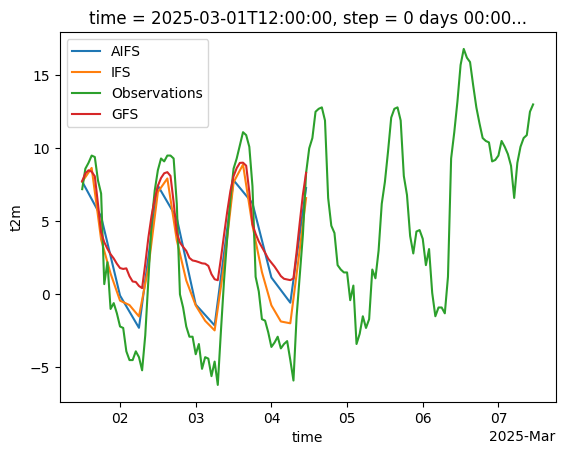

In [56]:
(aifs_ds_list[0]-273.15).plot(label="AIFS")
(ifs_ds_list[0]-273.15).plot(label="IFS")

plt.plot(df_benson["valid_time"], df_benson["T(C)"], label="Observations")

gfs_plot = gfs_ds_interp.isel(init_time=0)
plt.plot(gfs_plot.valid_time, gfs_plot, label="GFS")

plt.legend()

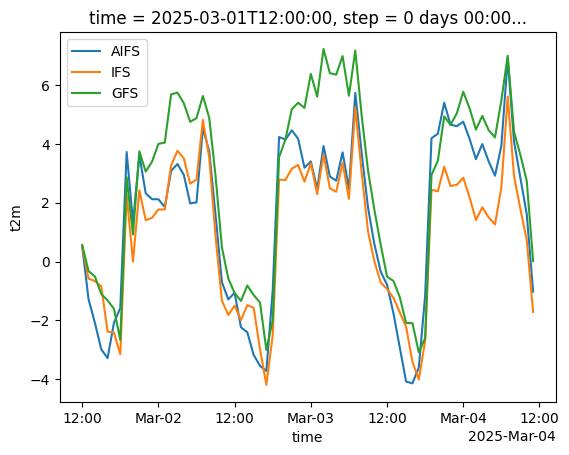

In [58]:
# Residual error
(aifs_ds_list[0]-273.15-df_benson["T(C)"].to_numpy()[:72]).plot(label="AIFS")
(ifs_ds_list[0]-273.15-df_benson["T(C)"].to_numpy()[:72]).plot(label="IFS")

gfs_plot = gfs_ds_interp.isel(init_time=0)
plt.plot(gfs_plot.valid_time, gfs_plot-df_benson["T(C)"].to_numpy()[:72], label="GFS")

plt.legend()

Saving data

In [ ]:
df_training = pl.DataFrame({
    "valid_time": df_benson["valid_time"][:72],
    "aifs_t2m": (aifs_ds_list[0]-273.15).to_numpy(),
    "ifs_t2m": (ifs_ds_list[0]-273.15).to_numpy(),
    "gfs_t2m": gfs_ds_interp.isel(init_time=0).to_numpy(),
    "obs_t2m": df_benson["T(C)"][:72],
})
df_training.write_parquet(".../scratch/ml_weather_forecasting/training_data/blend_training_data.parquet")

In [ ]:
df_test = pl.DataFrame({
    "valid_time": df_benson["valid_time"][72:],
    "aifs_t2m": (aifs_ds_list[1]-273.15).to_numpy(),
    "ifs_t2m": (ifs_ds_list[1]-273.15).to_numpy(),
    "gfs_t2m": gfs_ds_interp.isel(init_time=1).to_numpy(),
    "obs_t2m": df_benson["T(C)"][72:],
})
df_test.write_parquet(".../scratch/ml_weather_forecasting/training_data/blend_test_data.parquet")